In [3]:
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!ls -lh

total 250M
-rw-rw-r-- 1 nupoor.assudani nupoor.assudani 104K Jun  2  2023 dog.jpeg
-rw-rw-r-- 1 nupoor.assudani nupoor.assudani  32M Mar 17 02:14 f2lg_sahi.ipynb
-rw-rw-r-- 1 nupoor.assudani nupoor.assudani 1.2K Jan 11 15:26 file1.ipynb
drwxrwxr-x 7 nupoor.assudani nupoor.assudani 4.0K Mar 17 10:40 florence2_finetuning
-rw-rw-r-- 1 nupoor.assudani nupoor.assudani  99M Feb  2 15:44 florence2_la15_sr.ipynb
-rw-rw-r-- 1 nupoor.assudani nupoor.assudani  63M Feb 10 09:59 florence2_la_m15_sr_patches.ipynb
-rw-rw-r-- 1 nupoor.assudani nupoor.assudani  17M Feb 10 15:18 florence2lg_la15.ipynb
-rw-rw-r-- 1 nupoor.assudani nupoor.assudani  16M Jan 24 11:51 florence2_stats_up_most15.ipynb
-rw-rw-r-- 1 nupoor.assudani nupoor.assudani 8.0M Jan 27 10:05 florence2_zeroshot.ipynb
-rw-rw-r-- 1 nupoor.assudani nupoor.assudani  19M Mar 13 13:43 florence_stats.ipynb
-rw-rw-r-- 1 nupoor.assudani nupoor.assudani 4.3K Mar 19 11:26 learn_fl2_ft.ipynb
drwxrwxr-x 2 nupoor.assudani nupoor.assudani 4.0K Jan 21 10:

In [4]:
EXAMPLE_IMAGE_PATH = "dog.jpeg"

In [6]:
# @title Imports

import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
import supervision as sv

from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
from roboflow import Roboflow

In [35]:
CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION)

In [12]:
image = Image.open(EXAMPLE_IMAGE_PATH)
print(image.size)

(720, 1280)


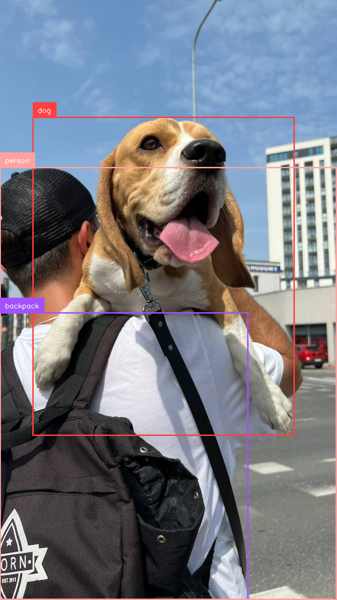

In [8]:
# @title Example object detection inference

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<OD>"
text = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [9]:
image.size

(337, 600)

In [36]:
# @title Example image captioning inference

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<DETAILED_CAPTION>"
text = "<DETAILED_CAPTION>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
response

{'<DETAILED_CAPTION>': 'In this image we can see a person wearing a bag and holding a dog. In the background there are buildings, poles and sky with clouds.'}

In [11]:
image.size

(720, 1280)

In [ ]:
# ROBOFLOW_API_KEY = "FcAdQtpvoDbQjwJGQklg"
# rf = Roboflow(api_key=ROBOFLOW_API_KEY)

# project = rf.workspace("roboflow-jvuqo").project("poker-cards-fmjio")
# version = project.version(4)
# dataset = version.download("florence2-od")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to poker-cards-4 in florence2-od:: 100%|██████████| 907/907 [00:00<00:00, 8747.17it/s]


In [ ]:
# dataset.location

'/home/nupoor.assudani/cs299_main/poker-cards-4'

In [42]:
dataset_path = "/home/nupoor.assudani/cs299_main/poker-cards-224"  # Change this to your actual path

# Define paths for train and validation datasets
train_jsonl_path = os.path.join(dataset_path, "train", "annotations.jsonl")
train_image_dir = os.path.join(dataset_path, "train")

val_jsonl_path = os.path.join(dataset_path, "valid", "annotations.jsonl")
val_image_dir = os.path.join(dataset_path, "valid")

In [ ]:
# !head -n 5 {dataset.location}/train/annotations.jsonl

{"image":"IMG_20220316_172418_jpg.rf.e3cb4a86dc0247e71e3697aa3e9db923.jpg","prefix":"<OD>","suffix":"9 of clubs<loc_138><loc_100><loc_470><loc_448>10 of clubs<loc_388><loc_145><loc_670><loc_453>jack  of clubs<loc_566><loc_166><loc_823><loc_432>queen of clubs<loc_365><loc_465><loc_765><loc_999>king of clubs<loc_601><loc_440><loc_949><loc_873>"}
{"image":"IMG_20220316_171515_jpg.rf.e3b1932bb375b3b3912027647586daa8.jpg","prefix":"<OD>","suffix":"5 of clubs<loc_554><loc_2><loc_763><loc_467>6 of clubs<loc_399><loc_79><loc_555><loc_466>7 of clubs<loc_363><loc_484><loc_552><loc_905>8 of clubs<loc_535><loc_449><loc_757><loc_971>"}
{"image":"IMG_20220316_165139_jpg.rf.e30257ec169a2bfdfecb693211d37250.jpg","prefix":"<OD>","suffix":"9 of diamonds<loc_596><loc_535><loc_859><loc_982>jack of diamonds<loc_211><loc_546><loc_411><loc_880>queen of diamonds<loc_430><loc_34><loc_692><loc_518>king of diamonds<loc_223><loc_96><loc_451><loc_523>10 of diamonds<loc_387><loc_542><loc_604><loc_925>"}
{"image":"I

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# # @title Define `DetectionsDataset` class

# class JSONLDataset:
#     def __init__(self, jsonl_file_path: str, image_directory_path: str):
#         self.jsonl_file_path = jsonl_file_path
#         self.image_directory_path = image_directory_path
#         self.entries = self._load_entries()

#     def _load_entries(self) -> List[Dict[str, Any]]:
#         entries = []
#         with open(self.jsonl_file_path, 'r') as file:
#             for line in file:
#                 data = json.loads(line)
#                 entries.append(data)
#         return entries

#     def __len__(self) -> int:
#         return len(self.entries)

#     def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
#         if idx < 0 or idx >= len(self.entries):
#             raise IndexError("Index out of range")

#         entry = self.entries[idx]
#         image_path = os.path.join(self.image_directory_path, entry['image'])
#         try:
#             image = Image.open(image_path)
#             return (image, entry)
#         except FileNotFoundError:
#             raise FileNotFoundError(f"Image file {image_path} not found.")


# class DetectionDataset(Dataset):
#     def __init__(self, jsonl_file_path: str, image_directory_path: str):
#         self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         image, data = self.dataset[idx]
#         prefix = data['prefix']
#         suffix = data['suffix']
#         return prefix, suffix, image

In [43]:
class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file {image_path} not found.")

        image = Image.open(image_path)
        return (image, entry)


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data.get('prefix', '')  # Avoid KeyError
        suffix = data.get('suffix', '')
        return prefix, suffix, image


# Define batch size and workers
BATCH_SIZE = 6
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

# Initialize train and validation datasets
train_dataset = DetectionDataset(jsonl_file_path=train_jsonl_path, image_directory_path=train_image_dir)
val_dataset = DetectionDataset(jsonl_file_path=val_jsonl_path, image_directory_path=val_image_dir)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

# 🔹 Now, your local dataset is loaded correctly and used instead of Roboflow's dataset.

In [ ]:
# # @title Initiate `DetectionsDataset` and `DataLoader` for train and validation subsets

# BATCH_SIZE = 6
# NUM_WORKERS = 0

# def collate_fn(batch):
#     questions, answers, images = zip(*batch)
#     inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
#     return inputs, answers

# train_dataset = DetectionDataset(
#     jsonl_file_path = f"{dataset.location}/train/annotations.jsonl",
#     image_directory_path = f"{dataset.location}/train/"
# )
# val_dataset = DetectionDataset(
#     jsonl_file_path = f"{dataset.location}/valid/annotations.jsonl",
#     image_directory_path = f"{dataset.location}/valid/"
# )

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [44]:
# @title Setup LoRA Florence-2 model

config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    revision=REVISION
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 1,929,928 || all params: 272,733,896 || trainable%: 0.7076



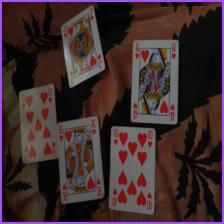
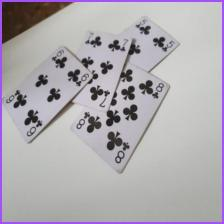
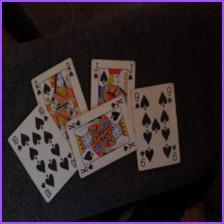
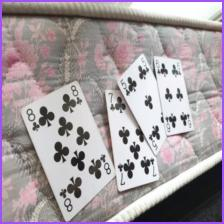

In [45]:
# @title Run inference with pre-trained Florence-2 model on validation dataset

def render_inline(image: Image.Image, resize=(128, 128)):
    """Convert image into inline html."""
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image: Image.Image, response):
    try:
        detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
        image = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
        image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image, detections)
    except:
        print('failed to redner model response')
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:256px; height:256px;" src="{render_inline(image, resize=(128, 128))}" />
    <p style="width:512px; margin:10px; font-size:small;">{html.escape(json.dumps(response))}</p>
</div>
"""


def render_inference_results(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        answer = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        html_out += render_example(image, answer)

    display(HTML(html_out))

render_inference_results(peft_model, val_dataset, 4)

In [19]:
# @title Define train loop

def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    render_inference_results(peft_model, val_loader.dataset, 6)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            render_inference_results(peft_model, val_loader.dataset, 6)

        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



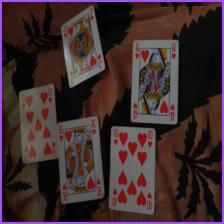
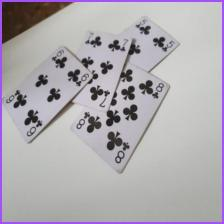
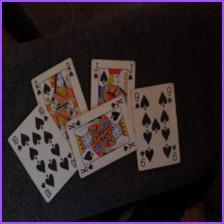
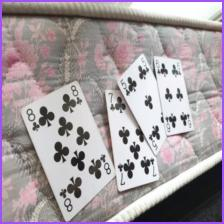
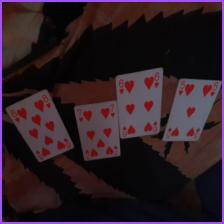
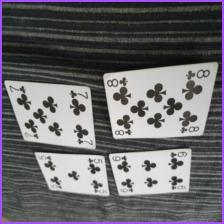

Training Epoch 1/5: 100%|██████████| 136/136 [01:29<00:00,  1.52it/s]


Average Training Loss: 4.940251469612122


Validation Epoch 1/5: 100%|██████████| 8/8 [00:03<00:00,  2.65it/s]


Average Validation Loss: 3.65797159075737



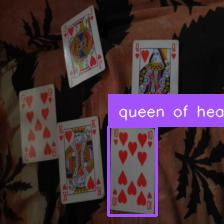
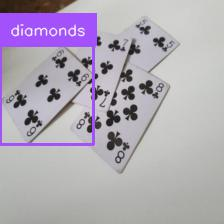
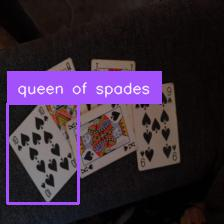
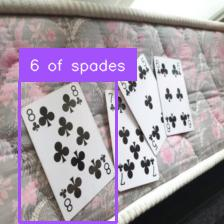
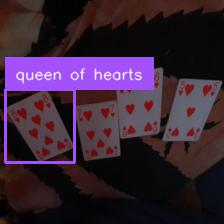
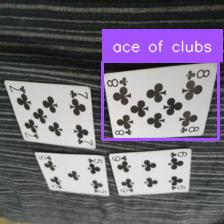

Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
Training Epoch 2/5: 100%|██████████| 136/136 [01:27<00:00,  1.55it/s]


Average Training Loss: 3.6229636581505047


Validation Epoch 2/5: 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


Average Validation Loss: 2.881018787622452



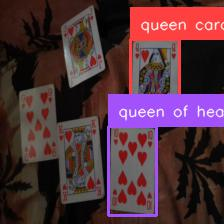
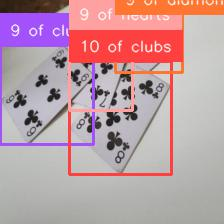
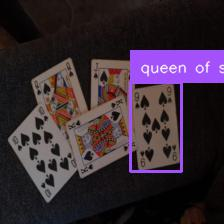
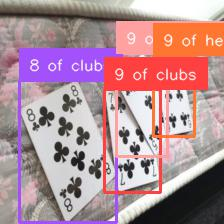
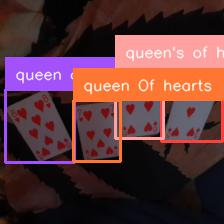
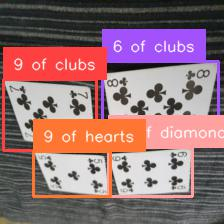

Training Epoch 3/5: 100%|██████████| 136/136 [01:28<00:00,  1.54it/s]


Average Training Loss: 2.9377324616207794


Validation Epoch 3/5: 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


Average Validation Loss: 2.363372355699539



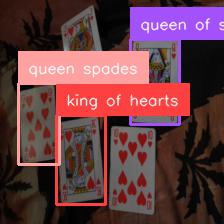
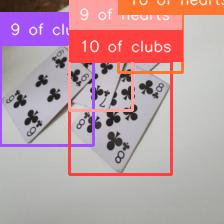
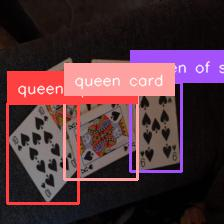
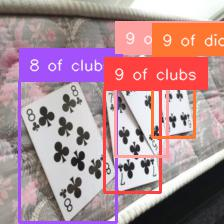
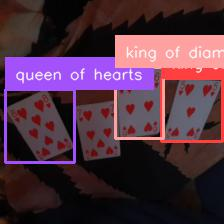
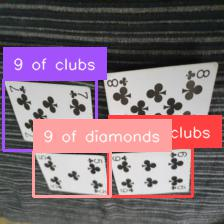

Training Epoch 4/5: 100%|██████████| 136/136 [01:28<00:00,  1.54it/s]


Average Training Loss: 2.50294235699317


Validation Epoch 4/5: 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


Average Validation Loss: 2.060127854347229



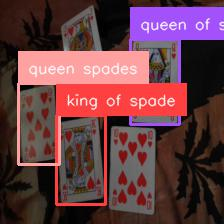
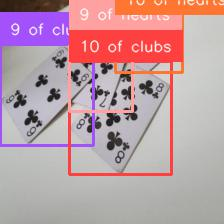
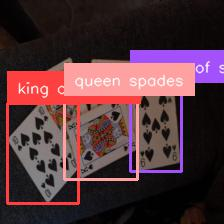
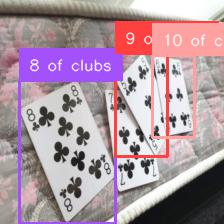
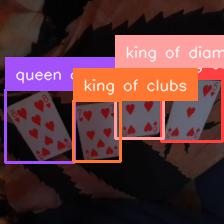
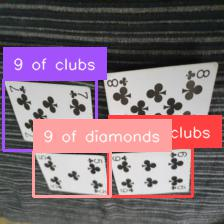

Training Epoch 5/5: 100%|██████████| 136/136 [01:29<00:00,  1.51it/s]


Average Training Loss: 2.2776759810307445


Validation Epoch 5/5: 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


Average Validation Loss: 1.9831108748912811



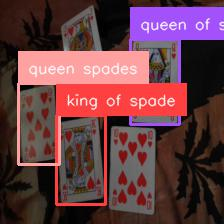
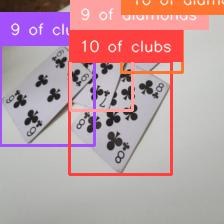
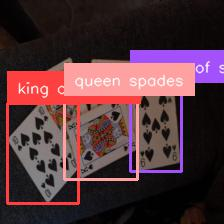
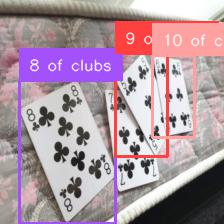
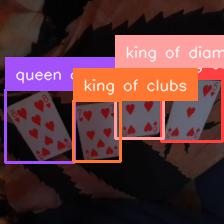
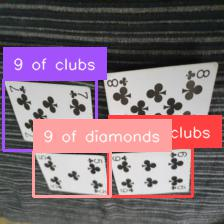

In [46]:
# @title Run train loop

EPOCHS = 5
LR = 5e-6

train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)

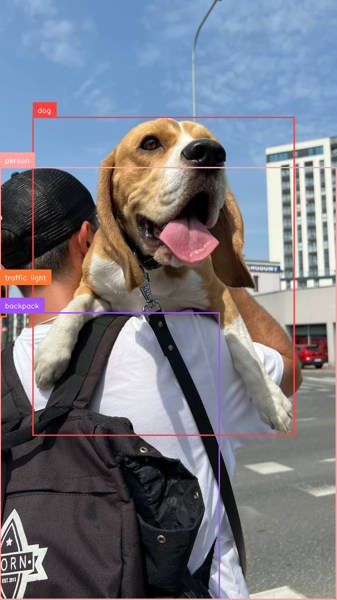

In [47]:
# @title Check if the model can still detect objects outside of the custom dataset

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<OD>"
text = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = peft_model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [48]:
# @title Collect predictions

PATTERN = r'([a-zA-Z0-9 ]+ of [a-zA-Z0-9 ]+)<loc_\d+>'

def extract_classes(dataset: DetectionDataset):
    class_set = set()
    for i in range(len(dataset.dataset)):
        image, data = dataset.dataset[i]
        suffix = data["suffix"]
        classes = re.findall(PATTERN, suffix)
        class_set.update(classes)
    return sorted(class_set)

CLASSES = extract_classes(train_dataset)

targets = []
predictions = []

for i in range(len(val_dataset.dataset)):
    image, data = val_dataset.dataset[i]
    prefix = data['prefix']
    suffix = data['suffix']

    inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    prediction = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
    prediction = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, prediction, resolution_wh=image.size)
    prediction = prediction[np.isin(prediction['class_name'], CLASSES)]
    prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
    prediction.confidence = np.ones(len(prediction))

    target = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
    target = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, target, resolution_wh=image.size)
    target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])

    targets.append(target)
    predictions.append(prediction)

In [49]:
# @title Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.16
map50: 0.17
map75: 0.17


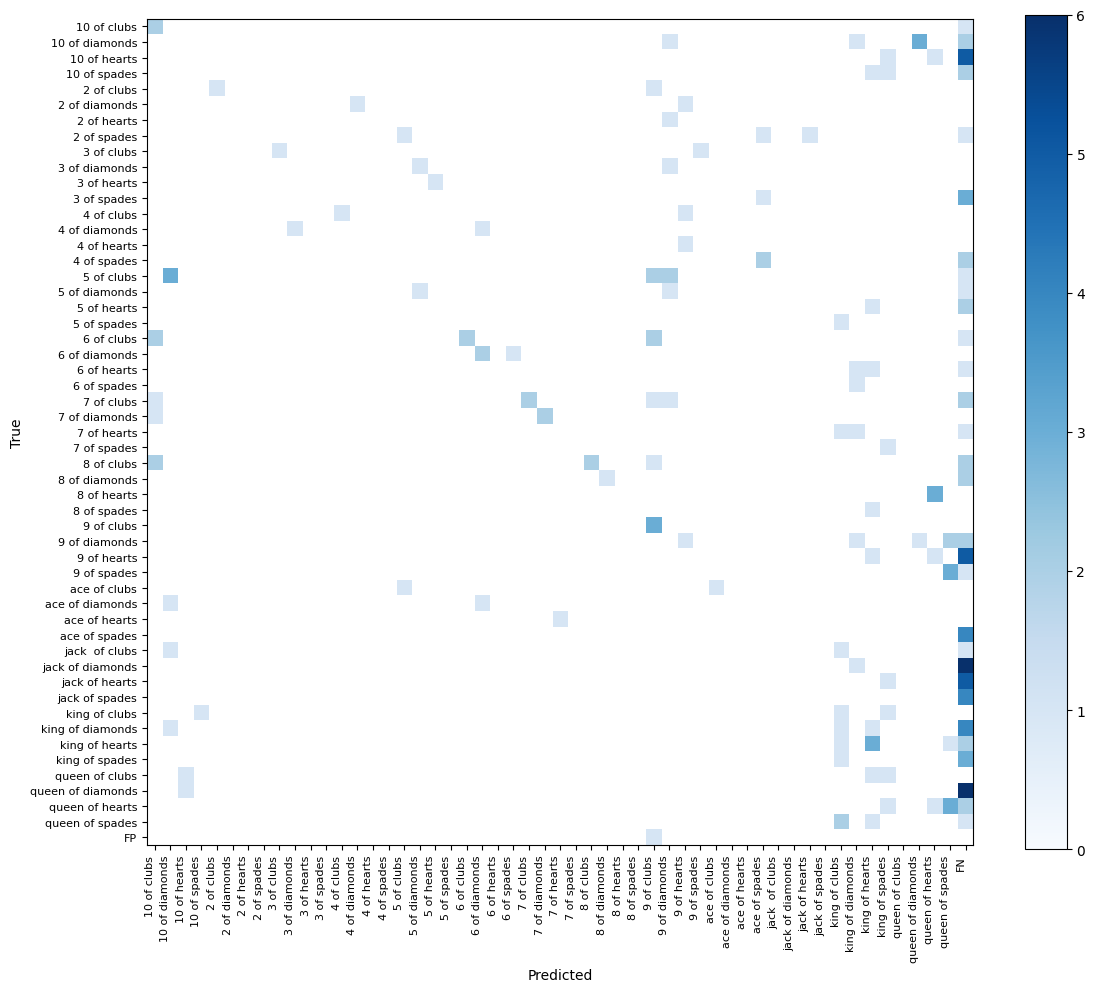

In [50]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

In [29]:
_224 = "/home/nupoor.assudani/cs299_main/poker-cards-224"
test_224 = "/home/nupoor.assudani/cs299_main/poker-cards-224/test"
train_224 = "/home/nupoor.assudani/cs299_main/poker-cards-224/train"
valid_224 = "/home/nupoor.assudani/cs299_main/poker-cards-224/valid"

test = "/home/nupoor.assudani/cs299_main/poker-cards-4/test"
train = "/home/nupoor.assudani/cs299_main/poker-cards-4/train"
valid = "/home/nupoor.assudani/cs299_main/poker-cards-4/valid"

from torchvision import transforms

# Define the transformation
resize_transform = transforms.Resize((224, 224))

In [ ]:
# # Paths
# input_dir = valid
# output_dir = valid_224

# # Loop through images and resize
# for filename in os.listdir(input_dir):
#     if filename.endswith(".jpg") or filename.endswith(".png"):  # Adjust extensions as needed
#         img_path = os.path.join(input_dir, filename)
#         img = Image.open(img_path).convert("RGB")  # Convert to RGB if needed
#         resized_img = resize_transform(img)
#         resized_img.save(os.path.join(output_dir, filename))

# print("Resized dataset created at:", output_dir)

Resized dataset created at: /home/nupoor.assudani/cs299_main/poker-cards-224/valid


In [ ]:
peft_model.save_pretrained("/home/nupoor.assudani/cs299_main/florence-trained-poker224")
processor.save_pretrained("/home/nupoor.assudani/cs299_main/florence-trained-poker224")

Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.


[]